## Feature selection

A popular method of feature selection consists of randomly shuffling the values of a specific variable and determining how that permutation affects the performance metric of the machine learning algorithm. In other words, the idea is to shuffle the values of each feature, one feature at a time, and measure how much the permutation (or shuffling of its values) decreases the accuracy, or the roc_auc, or the mse of the machine learning model (or any other performance metric!). If the variables are important, a random permutation of their values will dramatically decrease any of these metrics. Contrarily, the permutation or shuffling of values should have little to no effect on the model performance metric we are assessing.

The procedure goes more or less like this:

Build a machine learning model and store its performance metrics.

Shuffle 1 feature, and make a new prediction using the previous model.

Determine the performance of this prediction.

Determine the change in the performance of the prediction with the shuffled feature compared to the original one.

Repeat for each feature.

To select features, we chose those that induced a decrease in model performance beyond an arbitrarily set threshold.

I will demonstrate how to select features based on random shuffling using a regression and classification problem. 

Note For the demonstration, I will continue to use Random Forests, but this selection procedure can be used with any machine learning algorithm. In fact, the importance of the features is determined specifically for the algorithm used. Therefore, different algorithms may return different subsets of important features.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import os

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SelectByShuffling

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

import xgboost as xgb
from xgboost import XGBClassifier
from ngboost import NGBClassifier
from ngboost.distns import k_categorical

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score

In [3]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH")
dataset = pd.read_csv(dataset_path)
dataset.head()

,RID,Gender,Ageatscreening,Diagnosis,MMSE0m,HipsASMbaseline,HipsContrastbaseline,HipsCorelationbaseline,HipsVariancebaseline,HipsSumAveragebaseline,...,ERCsContrastbaseline,ERCsCorelationbaseline,ERCsVariancebaseline,ERCsSumAveragebaseline,ERCsSumVariancebaseline,ERCsEntropybaseline,ERCsClusterShadebaseline,ERCs_thicknessbaseline,ERCsVolumebaseline,HipposcampusVolumebaseline
0,3,0,81.3479,3,20.0,NaN,158.27,0.63,218.30,28.37,...,253.10,0.40,208.65,23.39,581.50,NaN,-2568.19,2.31,1176.0,3047.0
1,4,0,67.6904,1,27.0,0.06,147.64,0.55,173.64,44.72,...,220.88,0.48,215.70,33.74,641.90,3.33,4113.01,2.76,1942.0,3449.0
2,5,0,73.8027,0,29.0,0.10,199.66,0.55,222.27,41.18,...,220.37,0.54,232.18,29.18,708.36,2.87,-1388.41,3.18,2044.0,3441.0
3,8,1,84.5945,0,28.0,0.08,184.21,0.53,201.55,43.04,...,198.42,0.54,220.48,26.68,683.50,2.77,-2506.55,2.68,1959.0,2875.0
4,10,1,73.9726,3,24.0,0.11,233.02,0.48,229.88,39.46,...,196.55,0.53,210.63,26.60,645.95,2.72,-1164.02,2.64,1397.0,2700.0


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop("Diagnosis", axis=1),  
    dataset["Diagnosis"],  
    test_size=0.3,  
    random_state=42,  
)

In [5]:
imputer_missForest = IterativeImputer(
    estimator=ExtraTreesRegressor(n_estimators=10, random_state=42),
    max_iter=10,
    random_state=42,
)

imputer_missForest.fit(X_train)
X_train_missForest = imputer_missForest.transform(X_train)
X_test_missForest = imputer_missForest.transform(X_test)

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [6]:
X_train_missForest_t = pd.DataFrame(
    X_train_missForest, 
    columns=X_train.columns, 
    index=X_train.index  # Critical fix
)
X_test_missForest_t = pd.DataFrame(
    X_test_missForest, 
    columns=X_test.columns, 
    index=X_test.index  # Critical fix
)

In [7]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_missForest_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [8]:
constant_step = pipe.named_steps['constant']
quasi_constant_step = pipe.named_steps['quasi-constant']
duplicated_step = pipe.named_steps['duplicated']

print("Constant features removed:", constant_step.features_to_drop_)
print("Quasi-constant features removed:", quasi_constant_step.features_to_drop_)
print("Duplicate features removed:", duplicated_step.features_to_drop_)

Constant features removed: []
Quasi-constant features removed: []
Duplicate features removed: set()


In [9]:
X_train_t = pipe.transform(X_train_missForest_t)
X_test_t = pipe.transform(X_test_missForest_t)

X_train_t.shape, X_test_t.shape

((425, 23), (183, 23))

In [10]:
model = GradientBoostingClassifier(
    n_estimators=10,
    max_depth=2,
    random_state=42,
)

sel = SelectByShuffling(
    variables=None, # automatically examine all numerical variables
    estimator=model, # the ML model
    scoring='balanced_accuracy', # the metric to evaluate
    threshold=0,# the maximum performance drop allowed to select the feature
    cv=5, # cross validation
    random_state=1 # seed
)

sel.fit(X_train_t, y_train)

SelectByShuffling(cv=5,
                  estimator=GradientBoostingClassifier(max_depth=2,
                                                       n_estimators=10,
                                                       random_state=42),
                  random_state=1, scoring='balanced_accuracy', threshold=0)

In [11]:
# performance of model trained using all features

sel.initial_model_performance_

np.float64(0.5378956643611816)

In [12]:
# drop in performance caused by shuffling the feature

sel.performance_drifts_

{'RID': np.float64(0.005983397190293727),
 'Gender': np.float64(-0.0017857142857142794),
 'Ageatscreening': np.float64(-0.004510582010581965),
 'MMSE0m': np.float64(0.24537037037037035),
 'HipsASMbaseline': np.float64(0.0),
 'HipsContrastbaseline': np.float64(-0.0038888888888888307),
 'HipsCorelationbaseline': np.float64(0.006639962846859415),
 'HipsVariancebaseline': np.float64(-0.003214285714285725),
 'HipsSumAveragebaseline': np.float64(0.0),
 'HipsSumVariancebaseline': np.float64(0.0018518518518518823),
 'HipsEntropybaseline': np.float64(0.010784984491881033),
 'HipsClusterShadebaseline': np.float64(0.0),
 'ERCsASMbaseline': np.float64(0.0),
 'ERCsContrastbaseline': np.float64(-0.0019047619047619646),
 'ERCsCorelationbaseline': np.float64(-0.002777777777777768),
 'ERCsVariancebaseline': np.float64(0.0),
 'ERCsSumAveragebaseline': np.float64(0.0),
 'ERCsSumVariancebaseline': np.float64(0.0),
 'ERCsEntropybaseline': np.float64(-0.004545454545454519),
 'ERCsClusterShadebaseline': np.f

<Axes: >

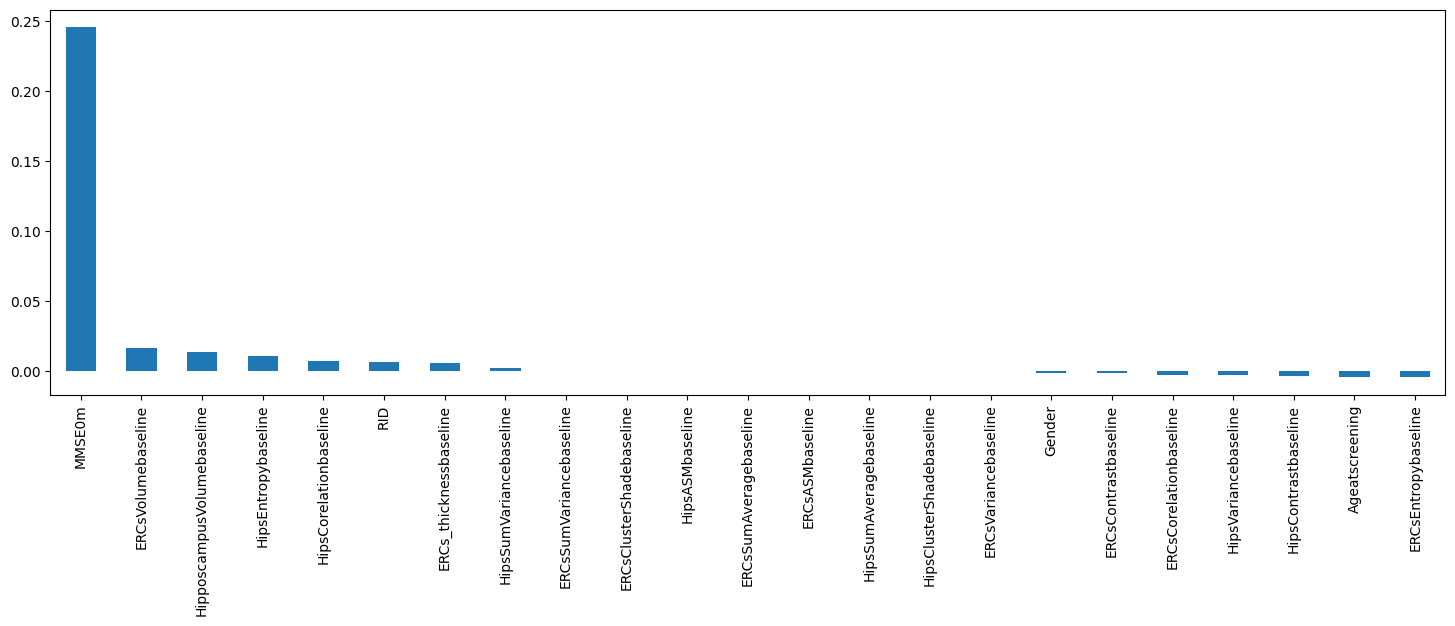

In [13]:
# bar plot of the performance drops

pd.Series(sel.performance_drifts_).sort_values(ascending=False).plot.bar(figsize=(18,5))

In [14]:
# Number of features that will be removed

len(sel.features_to_drop_)

20

In [15]:
# select features
X_train_t = sel.transform(X_train)
X_test_t = sel.transform(X_test)

X_train_t.shape, X_test_t.shape

((425, 3), (183, 3))

## Classification Test

In [16]:
def run_model(classifier_name, X_train, y_train):

        # Initialize the model based on classifier_name
        if classifier_name == "Random Forest":
                model = RandomForestClassifier(n_estimators=100, 
                                        max_depth=5, 
                                        random_state=42, 
                                        class_weight="balanced")
                
        elif classifier_name == "XGBoost":
        # XGBClassifier sometimes issues warnings about label encoding. 
        # We disable the use_label_encoder and set an evaluation metric.
                model = XGBClassifier(n_estimators=100, 
                                max_depth=5, 
                                random_state=42,
                                eval_metric="logloss")
        
        elif classifier_name == "NGBoost":
                model = NGBClassifier(Dist=k_categorical(len(np.unique(y_train))),
                                      n_estimators=100,
                                      verbose=False) 

        else:
                raise ValueError("Unknown classifier")
                
        kf = StratifiedKFold(n_splits=10,
                             shuffle=True,
                             random_state=42,
        )
        
        cross_val_results = cross_validate(model,
                                           X_train,
                                           y_train,
                                           cv=kf,
                                           scoring="balanced_accuracy",
                                           return_train_score=True,
        )
               
        # Calculate the metrics for training and testing
        mean_train = [round(np.mean(cross_val_results["train_score"]), 3)]
        std_train = [round(np.std(cross_val_results["train_score"]), 3)]
        mean_test = [round(np.mean(cross_val_results["test_score"]), 3)]
        std_test = [round(np.std(cross_val_results["test_score"]), 3)]
        time = round(np.mean(cross_val_results["fit_time"]), 3)
                
        cv_metrics_df = pd.DataFrame({
                "Feature Selection": "Feature Shuffle",
                "Classifier": classifier_name,
                "Fit Time": time,
                "Total Features": len(X_train.columns),
                "Metric": "balanced_accuracy",
                "Mean Train": mean_train,
                "Std Train": std_train,
                "Mean Test": mean_test,
                "Std Test": std_test,
        })
        
        fit_model = model.fit(X_train, y_train)
        
        return fit_model, cv_metrics_df


In [17]:
trained_rf_n, metrics_rf_n = run_model("Random Forest", X_train_missForest_t, y_train)
trained_rf_t, metrics_rf_t = run_model("Random Forest", X_train_t, y_train)

trained_xgb_n, metrics_xgb_n = run_model("XGBoost", X_train_missForest_t, y_train)
trained_xgb_t, metrics_xgb_t = run_model("XGBoost", X_train_t, y_train)

trained_ngb_n, metrics_ngb_n = run_model("NGBoost", X_train_missForest_t, y_train)
trained_ngb_t, metrics_ngb_t = run_model("NGBoost", X_train_t, y_train)

In [22]:
validation_df = pd.concat([metrics_rf_n, metrics_rf_t, metrics_xgb_n, metrics_xgb_t, metrics_ngb_n, metrics_ngb_t])
validation_df_report = validation_df.set_index(["Feature Selection", "Classifier", "Fit Time", "Total Features", "Metric"])
validation_df_report

Mean Train  \
Feature Selection Classifier    Fit Time Total Features Metric                          
Feature Shuffle   Random Forest 0.337    23             balanced_accuracy       0.891   
                                0.288    3              balanced_accuracy       0.789   
                  XGBoost       0.740    23             balanced_accuracy       1.000   
                                0.452    3              balanced_accuracy       1.000   
                  NGBoost       2.059    23             balanced_accuracy       0.698   
                                0.735    3              balanced_accuracy       0.628   

                                                                           Std Train  \
Feature Selection Classifier    Fit Time Total Features Metric                         
Feature Shuffle   Random Forest 0.337    23             balanced_accuracy      0.010   
                                0.288    3              balanced_accuracy      0.007   
                  XGBoost       0.740    23             balanced_accuracy      0.000   
                                0.452    3              balanced_accuracy      0.000   
                  NGBoost       2.059    23             balanced_accuracy      0.020   
                                0.735    3              balanced_accuracy      0.008   

                                                                           Mean Test  \
Feature Selection Classifier    Fit Time Total Features Metric                         
Feature Shuffle   Random Forest 0.337    23             balanced_accuracy      0.575   
                                0.288    3              balanced_accuracy      0.570   
                  XGBoost       0.740    23             balanced_accuracy      0.556   
                                0.452    3              balanced_accuracy      0.533   
                  NGBoost       2.059    23             balanced_accuracy      0.548   
                                0.735    3              balanced_accuracy      0.542   

                                                                           Std Test  
Feature Selection Classifier    Fit Time Total Features Metric                       
Feature Shuffle   Random Forest 0.337    23             balanced_accuracy     0.062  
                                0.288    3              balanced_accuracy     0.064  
                  XGBoost       0.740    23             balanced_accuracy     0.050  
                                0.452    3              balanced_accuracy     0.069  
                  NGBoost       2.059    23             balanced_accuracy     0.052  
                                0.735    3              balanced_accuracy     0.060

In [19]:
import time

def eval_model(classifier_name, model, X_train, X_test, y_train, y_test):
        
        start_time = time.time()
        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        # Calculate metrics
        metrics_train = {
                "accuracy": round(accuracy_score(y_train, pred_train), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_train, pred_train), 3),
                "precision": round(precision_score(y_train, pred_train, average="weighted"), 3),
                "recall": round(recall_score(y_train, pred_train, average="weighted"), 3),
                "f1_weighted": round(f1_score(y_train, pred_train, average="weighted"), 3),
                "roc_auc_ovr_weighted": round(roc_auc_score(y_train, pred_train_proba, average="weighted", multi_class="ovr"),3,),
        }
        
        metrics_test = {
                "accuracy": round(accuracy_score(y_test, pred_test), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_test, pred_test), 3),
                "precision": round(precision_score(y_test, pred_test, average="weighted"), 3),
                "recall": round(recall_score(y_test, pred_test, average="weighted"), 3),
                "f1_weighted": round(f1_score(y_test, pred_test, average="weighted"), 3),
                "roc_auc_ovr_weighted": round(roc_auc_score(y_test, pred_test_proba, average="weighted", multi_class="ovr"),3,),
        }
                
        elapsed_time = time.time() - start_time
    
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Feature Selection": "Feature Shuffle",
                "Classifier": classifier_name,
                "Classification Time": round(elapsed_time, 3),
                "Total Features": len(X_train.columns),
                "Metric": metrics_train.keys(),
                "Train data": metrics_train.values(),
                "Test data": metrics_test.values(),
    })
        
        return pred_metrics_df

In [20]:
pred_rf_n = eval_model("Random Forest", trained_rf_n, X_train_missForest_t, X_test_missForest_t, y_train, y_test)
pred_rf_t = eval_model("Random Forest", trained_rf_t, X_train_t, X_test_t, y_train, y_test)

pred_xgb_n = eval_model("XGBoost", trained_xgb_n, X_train_missForest_t, X_test_missForest_t, y_train, y_test)
pred_xgb_t = eval_model("XGBoost", trained_xgb_t, X_train_t, X_test_t, y_train, y_test)

pred_ngb_n = eval_model("NGBoost", trained_ngb_n, X_train_missForest_t, X_test_missForest_t, y_train, y_test)
pred_ngb_t = eval_model("NGBoost", trained_ngb_t, X_train_t, X_test_t, y_train, y_test)

In [21]:
prediction_df = pd.concat([pred_rf_n, pred_rf_t, pred_xgb_n, pred_xgb_t, pred_ngb_n, pred_ngb_t])
prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])
prediction_df_report

Train data  \
Feature Selection Classifier    Classification Time Total Features Metric                             
Feature Shuffle   Random Forest 0.110               23             accuracy                   0.875   
                                                                   balanced_accuracy          0.881   
                                                                   precision                  0.880   
                                                                   recall                     0.875   
                                                                   f1_weighted                0.872   
                                                                   roc_auc_ovr_weighted       0.979   
                                0.074               3              accuracy                   0.781   
                                                                   balanced_accuracy          0.793   
                                                                   precision                  0.790   
                                                                   recall                     0.781   
                                                                   f1_weighted                0.776   
                                                                   roc_auc_ovr_weighted       0.938   
                  XGBoost       0.111               23             accuracy                   1.000   
                                                                   balanced_accuracy          1.000   
                                                                   precision                  1.000   
                                                                   recall                     1.000   
                                                                   f1_weighted                1.000   
                                                                   roc_auc_ovr_weighted       1.000   
                                0.077               3              accuracy                   1.000   
                                                                   balanced_accuracy          1.000   
                                                                   precision                  1.000   
                                                                   recall                     1.000   
                                                                   f1_weighted                1.000   
                                                                   roc_auc_ovr_weighted       1.000   
                  NGBoost       0.356               23             accuracy                   0.755   
                                                                   balanced_accuracy          0.673   
                                                                   precision                  0.742   
                                                                   recall                     0.755   
                                                                   f1_weighted                0.730   
                                                                   roc_auc_ovr_weighted       0.950   
                                0.402               3              accuracy                   0.708   
                                                                   balanced_accuracy          0.618   
                                                                   precision                  0.716   
                                                                   recall                     0.708   
                                                                   f1_weighted                0.673   
                                                                   roc_auc_ovr_weighted       0.913   

                                                                                         Test data  
Feature Selection Classifier    Classification Time Total Features Metric